In [1]:
#!pip install -r "requirements.txt"

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = None

In [4]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
pokemon = pd.read_csv("./pokemon.csv", index_col="#")

In [5]:
train

,Winner,First_pokemon,Second_pokemon
0,44,28,44
1,466,126,466
2,410,410,532
3,496,474,496
4,699,699,458
...,...,...,...
31995,40,40,708
31996,496,496,762
31997,770,763,770
31998,490,490,698


# Analisi

In [35]:
train.dtypes

Winner            int64
First_pokemon     int64
Second_pokemon    int64
dtype: object

In [7]:
pokemon.dtypes

Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

## Valori mancanti / nulli

In [8]:
pokemon.isnull().sum()

Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [9]:
train.isnull().sum()

Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

In [10]:
print(f"Missing (type 2) { len(pokemon[pokemon['Type 2'].isnull()]) / len(pokemon.index) * 100 }% ")

Missing (type 2) 48.25% 


### Considerazioni
- E' presente un Pokemon con un nome mancante
- 386 Pokemon non hanno un tipo 2 (48,25% del dataset di training)

## Percentuale di vincita
Viene definita la percentuale di vincita per ogni pokemon, allo scopo di poter analizzare come varia in base alle altre features.

In [11]:
winner_count = train.groupby("Winner").count()
win_percentage = winner_count['First_pokemon'] + winner_count['Second_pokemon'] / len(train.index) * 100
pokemon['win_percentage'] = win_percentage

## Analisi Feature "Type 1"
La tipologia determina la probabilità di vincita, pokemon di tipo "flying", "dragon", "dark", nel training set hanno vinto più volte in percentuale.

<AxesSubplot:xlabel='Type 1', ylabel='win_percentage'>

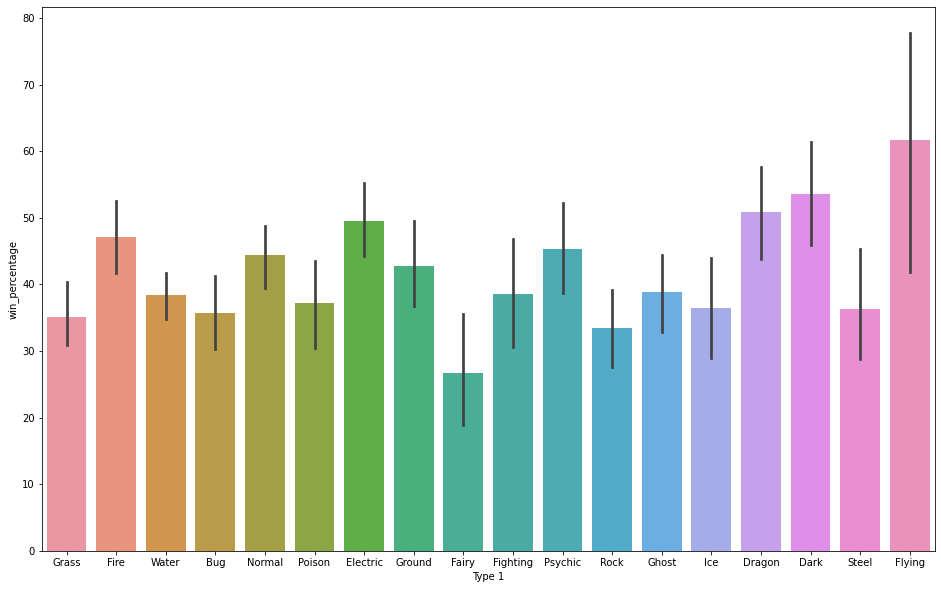

In [12]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Type 1", y="win_percentage", data=pokemon)

## Analisi Feature "Speed"
E' presente un trend positivo, all'aumentare della "speed" aumenta la percentuale di vittoria.

<AxesSubplot:xlabel='Speed', ylabel='win_percentage'>

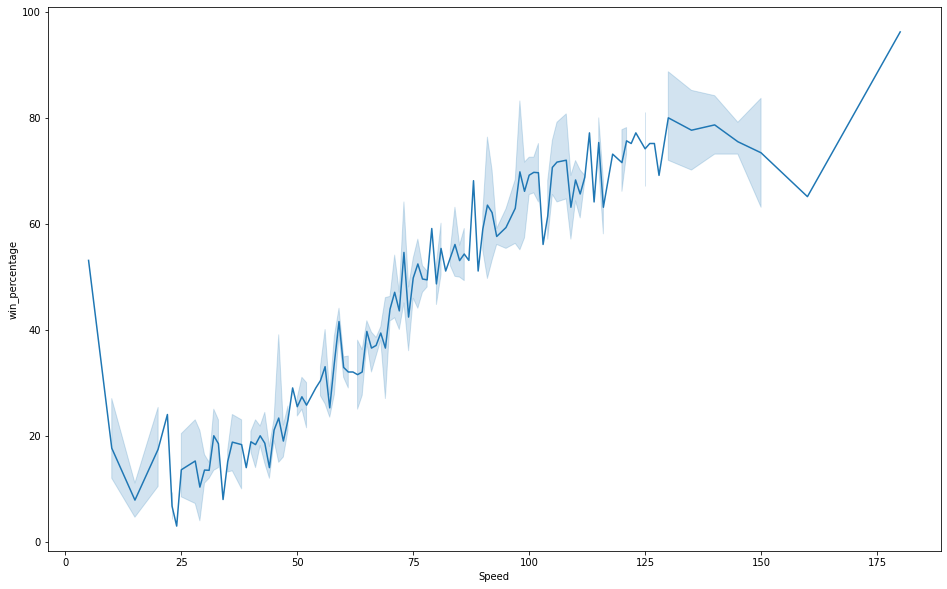

In [13]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Speed", y="win_percentage", data=pokemon)

## Analisi feature "Attack"
Anche la feature "attack" presenta una forte relazione con la percentuale di vittoria, sebbene presenti molte oscillazioni.

<AxesSubplot:xlabel='Attack', ylabel='win_percentage'>

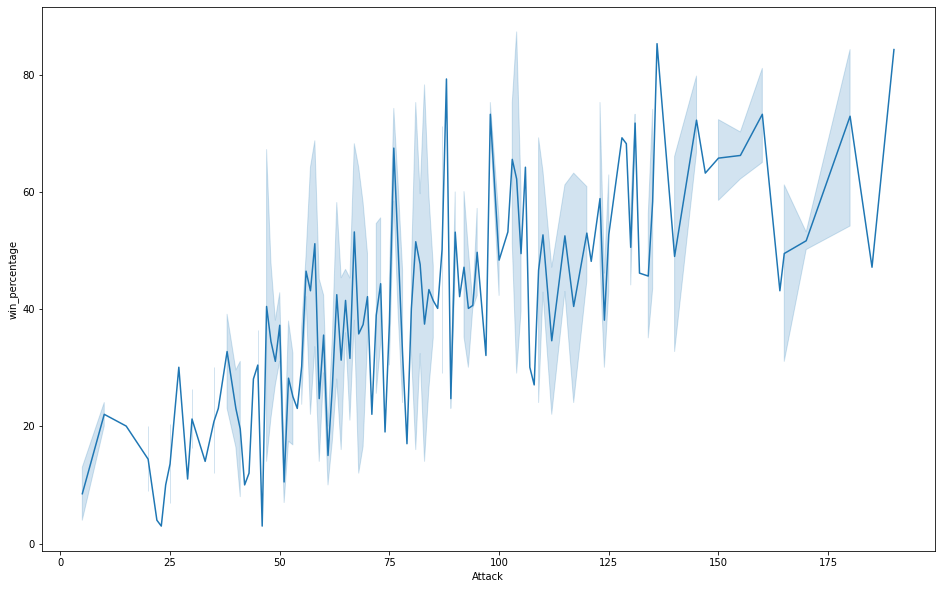

In [14]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Attack", y="win_percentage", data=pokemon)

## Analisi Feature "Defense"
La feature "Defense" sembra abbastanza randomica, presenta infatti un line chart ricco di oscillazioni

<AxesSubplot:xlabel='Defense', ylabel='win_percentage'>

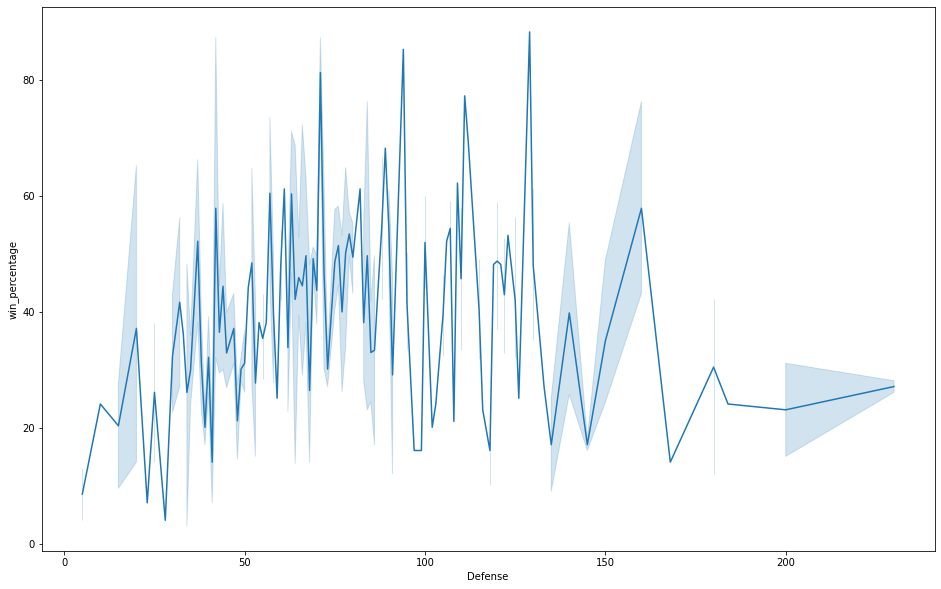

In [15]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Defense", y="win_percentage", data=pokemon)

## Analisi Feature "Generation"
La feature "Generation" presenta delle percentuali di vittoria molto simili tra di loro, pertanto è probaiblmente superfluea.

<AxesSubplot:xlabel='Generation', ylabel='win_percentage'>

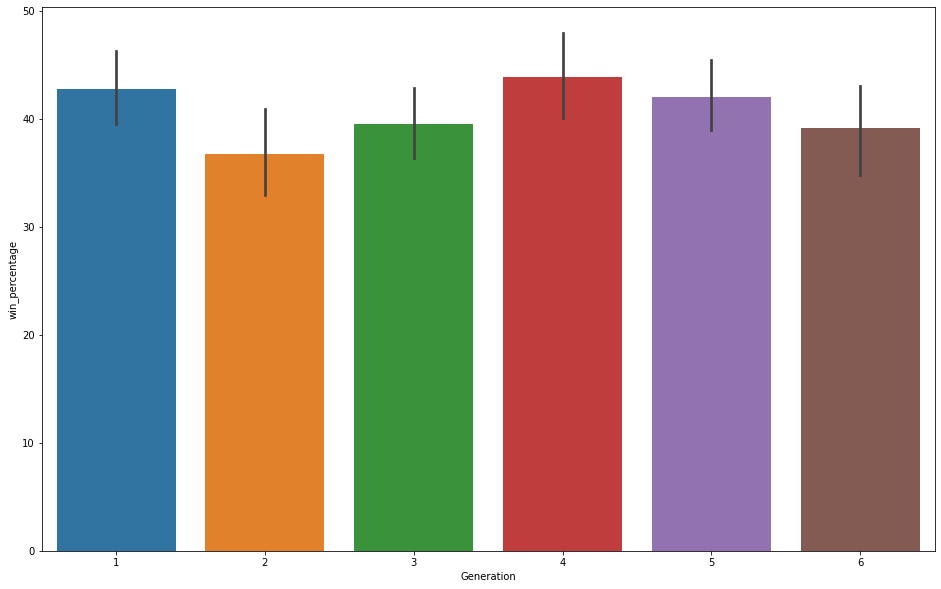

In [16]:
plt.figure(figsize=(16, 10))
sns.barplot(x="Generation", y="win_percentage", data=pokemon)

## Analisi Feature "Legendary"

<AxesSubplot:xlabel='Type 1', ylabel='win_percentage'>

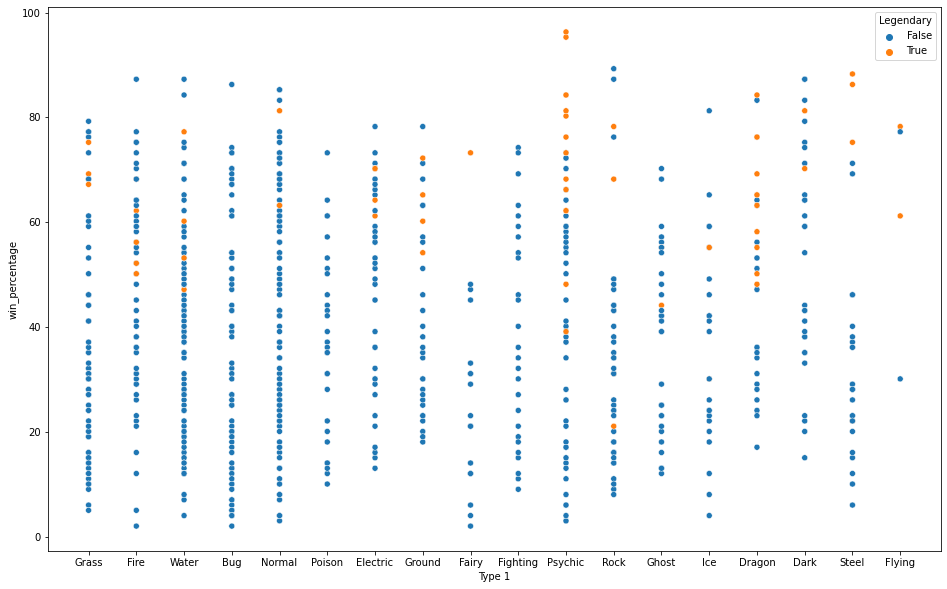

In [17]:
plt.figure(figsize=(16, 10))
sns.scatterplot(hue="Legendary", x="Type 1", y="win_percentage", data=pokemon)

<AxesSubplot:xlabel='Sp. Def', ylabel='win_percentage'>

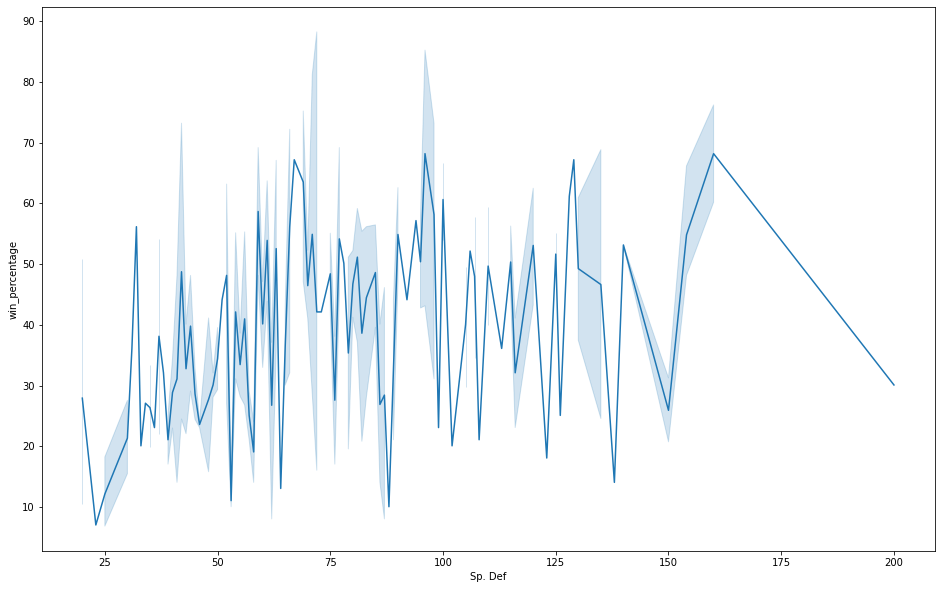

In [18]:
plt.figure(figsize=(16, 10))
sns.lineplot(x="Sp. Def", y="win_percentage", data=pokemon)

## Correlazione
La feature "Generation" ha una correlazione con "Win_percentage" prossima allo zero. Probabilmete può essere droppata.

<AxesSubplot:>

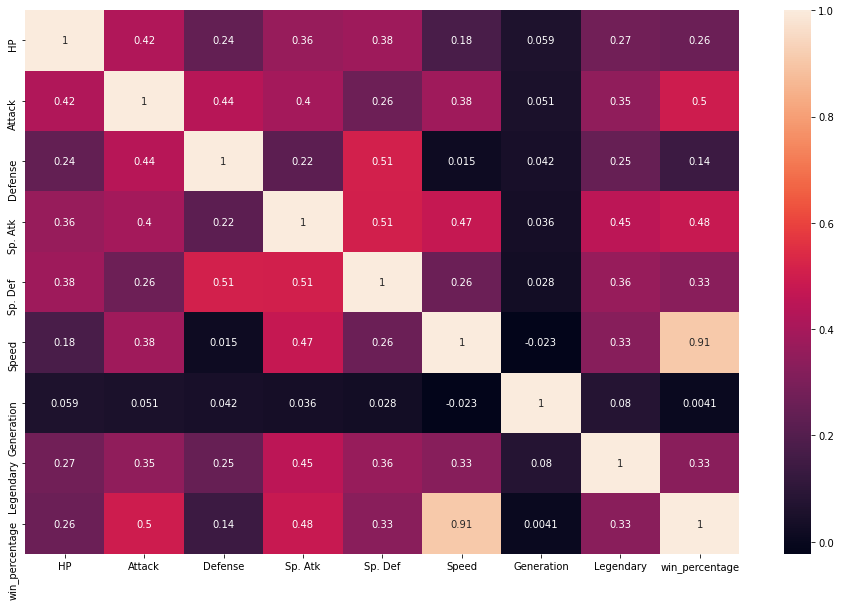

In [19]:
corr = pokemon.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

# Preprocessing

In [20]:
pokemon.drop(columns='win_percentage', inplace=True)
pokemon.drop(columns='Name', inplace=True)

In [21]:
def convertTarget(_df):
    df = _df.copy()
    df['Winner'] = (df['Winner'] == df['First_pokemon']).map(lambda el: 1 if el else 2)
    return df


In [22]:
train = convertTarget(train)
test = convertTarget(test)

In [23]:
pokemon.Legendary = pokemon.Legendary.map(lambda el: 1 if el else 0)

In [24]:
pokemon.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,
1,Grass,Poison,45,49,49,65,65,45,1,0
2,Grass,Poison,60,62,63,80,80,60,1,0
3,Grass,Poison,80,82,83,100,100,80,1,0
4,Grass,Poison,80,100,123,122,120,80,1,0
5,Fire,NaN,39,52,43,60,50,65,1,0


In [25]:
def mergePokemonsData(df):
    full_data = pd.merge(df, pokemon.add_prefix("First_pokemon_"), how="left", left_on=['First_pokemon'], right_index=True)
    full_data = pd.merge(full_data, pokemon.add_prefix("Second_pokemon_"), how="left", left_on=['Second_pokemon'],  right_index=True)
    full_data.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)
    return full_data

In [26]:
full_train_data = mergePokemonsData(train)
full_test_data = mergePokemonsData(test)
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_Type 2,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Defense,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Generation,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_Type 2,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Defense,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Generation,Second_pokemon_Legendary
0,2,Normal,Flying,65,90,65,61,61,100,1,0,Fire,NaN,73,76,75,81,100,100,1,0
1,2,Water,NaN,30,40,70,70,25,60,1,0,Water,NaN,55,65,35,60,30,85,4,0
2,1,Dragon,Flying,95,145,130,120,90,120,3,0,Electric,Ghost,50,50,77,95,77,91,4,0
3,2,Ghost,Flying,150,80,44,90,54,80,4,0,Normal,NaN,135,85,40,40,85,5,4,0
4,1,Bug,Fire,85,60,65,135,105,100,5,0,Bug,NaN,40,29,45,29,45,36,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,1,Poison,Ground,81,102,77,85,75,85,1,0,Dragon,Electric,100,150,120,120,100,90,5,1
31996,1,Normal,NaN,135,85,40,40,85,5,4,0,Poison,Dragon,65,75,90,97,123,44,6,0
31997,2,Water,NaN,50,53,62,58,63,44,6,0,Rock,Ice,123,77,72,99,92,58,6,0
31998,1,Normal,Flying,76,65,45,92,42,91,4,0,Bug,Fire,55,85,55,50,55,60,5,0


In [27]:
encoder = LabelEncoder()
categorical_cols = ['First_pokemon_Type 1', 'Second_pokemon_Type 1', "First_pokemon_Type 2", "Second_pokemon_Type 2"]
for col in categorical_cols:
    try:
        full_train_data[col] = encoder.fit_transform(full_train_data[col])
        full_test_data[col] = encoder.fit_transform(full_test_data[col])
    except:
        continue

In [28]:
full_train_data

,Winner,First_pokemon_Type 1,First_pokemon_Type 2,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Defense,First_pokemon_Sp. Atk,First_pokemon_Sp. Def,First_pokemon_Speed,First_pokemon_Generation,First_pokemon_Legendary,Second_pokemon_Type 1,Second_pokemon_Type 2,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Defense,Second_pokemon_Sp. Atk,Second_pokemon_Sp. Def,Second_pokemon_Speed,Second_pokemon_Generation,Second_pokemon_Legendary
0,2,12,7,65,90,65,61,61,100,1,0,6,18,73,76,75,81,100,100,1,0
1,2,17,18,30,40,70,70,25,60,1,0,17,18,55,65,35,60,30,85,4,0
2,1,2,7,95,145,130,120,90,120,3,0,3,8,50,50,77,95,77,91,4,0
3,2,8,7,150,80,44,90,54,80,4,0,12,18,135,85,40,40,85,5,4,0
4,1,0,6,85,60,65,135,105,100,5,0,0,18,40,29,45,29,45,36,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,1,13,10,81,102,77,85,75,85,1,0,2,3,100,150,120,120,100,90,5,1
31996,1,12,18,135,85,40,40,85,5,4,0,13,2,65,75,90,97,123,44,6,0
31997,2,17,18,50,53,62,58,63,44,6,0,15,11,123,77,72,99,92,58,6,0
31998,1,12,7,76,65,45,92,42,91,4,0,0,6,55,85,55,50,55,60,5,0


## Correlazione
Utilizzo la Correlazione dopo aver effettuato il merge, per confermare le ipotesi fatte durante l'analisi

<AxesSubplot:>

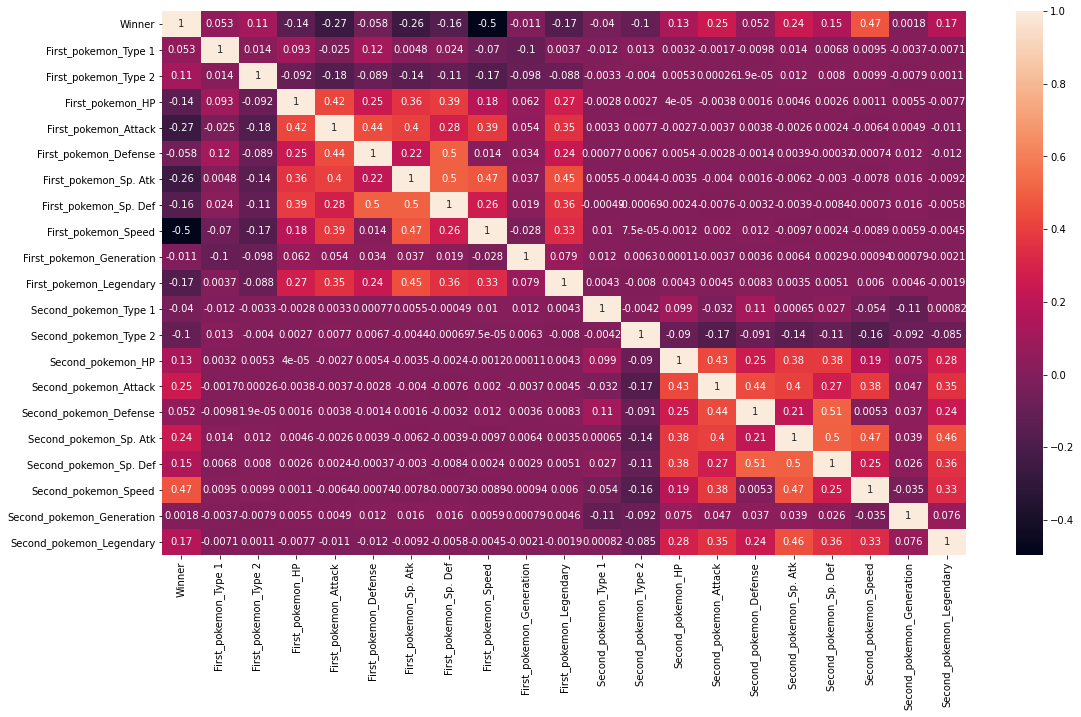

In [29]:
corr = full_train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

In [30]:
columns_to_drop = ['First_pokemon_Generation', "First_pokemon_Type 1", "First_pokemon_Type 2", "First_pokemon_Defense", "First_pokemon_Sp. Def", "Second_pokemon_Generation", "Second_pokemon_Type 1", "Second_pokemon_Type 2", "Second_pokemon_Defense", "Second_pokemon_Sp. Def"]
for col in columns_to_drop:
    try:
        full_train_data = full_train_data.drop(columns=col)
        full_test_data = full_test_data.drop(columns=col)
    except:
        continue

In [31]:
X_train = full_train_data.drop(columns=['Winner'])
y_train = full_train_data.Winner

X_test = full_test_data.drop(columns='Winner')
y_test = full_test_data.Winner
X_train

,First_pokemon_HP,First_pokemon_Attack,First_pokemon_Sp. Atk,First_pokemon_Speed,First_pokemon_Legendary,Second_pokemon_HP,Second_pokemon_Attack,Second_pokemon_Sp. Atk,Second_pokemon_Speed,Second_pokemon_Legendary
0,65,90,61,100,0,73,76,81,100,0
1,30,40,70,60,0,55,65,60,85,0
2,95,145,120,120,0,50,50,95,91,0
3,150,80,90,80,0,135,85,40,5,0
4,85,60,135,100,0,40,29,29,36,0
...,...,...,...,...,...,...,...,...,...,...
31995,81,102,85,85,0,100,150,120,90,1
31996,135,85,40,5,0,65,75,97,44,0
31997,50,53,58,44,0,123,77,99,58,0
31998,76,65,92,91,0,55,85,50,60,0


# Addestramento

Utilizzo il classificatore di tipo RandomForest, il quale utilizza un approccio basato su più alberi di decisione. Su questo dataset performa meglio di DecisionTree.

In [32]:
model = RandomForestClassifier(random_state=20)
model.fit(X_train, y_train)

print("Trained!")

Trained!


# Accuracy

In [33]:
train_score = model.score(X_train, y_train)
print(f"Train set score: {round(train_score, 2) * 100}%")

Train set score: 100.0%


In [34]:
test_score = model.score(X_test, y_test)
print(f"Test set score: {round(test_score, 5) * 100}%")

Test set score: 94.8%
